In [3]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/Ali-Asgar-Lakdawala/Tensorflow-2-and-Keras-Deep-Learning/main/Data/RSCCASN.csv',index_col='DATE',parse_dates=True)

In [11]:
df.columns = ['Sales']

In [12]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


<AxesSubplot:xlabel='DATE'>

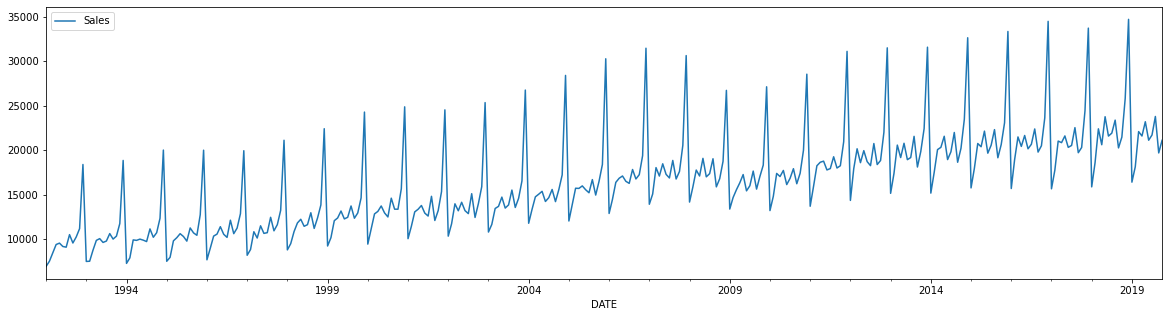

In [13]:
df.plot(figsize=(20,5))

In [16]:
test_size = 18

In [17]:
test_ind = len(df)- test_size

In [18]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [19]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [20]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
scaler=MinMaxScaler()

In [23]:
train_scaled=scaler.fit_transform(train)
test_scaled=scaler.transform(train)

In [25]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [34]:
length=12
batch_size=1

In [35]:
generator=TimeseriesGenerator(train_scaled,train_scaled,
                              length=length,batch_size=batch_size)

In [45]:
validaton_generator=TimeseriesGenerator(test_scaled,test_scaled,
                              length=length,batch_size=batch_size)

In [36]:
x,y=generator[0]

In [37]:
x

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [38]:
y

array([[0.02047633]])

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [41]:
n_features=1

In [49]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features),return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [50]:
early_stoping=EarlyStopping( monitor='val_loss',patience=2)

In [51]:
model.fit(generator,epochs=20,verbose=1,
          validation_data=validaton_generator,
          callbacks=[early_stoping])

Epoch 1/20
304/304 [==============================] - 41s 129ms/step - loss: 0.0242 - val_loss: 0.0168
Epoch 2/20
304/304 [==============================] - 47s 155ms/step - loss: 0.0188 - val_loss: 0.0129
Epoch 3/20
304/304 [==============================] - 52s 170ms/step - loss: 0.0116 - val_loss: 0.0202
Epoch 4/20
304/304 [==============================] - 56s 185ms/step - loss: 0.0059 - val_loss: 0.0029
Epoch 5/20
304/304 [==============================] - 59s 196ms/step - loss: 0.0052 - val_loss: 0.0029
Epoch 6/20
304/304 [==============================] - 66s 218ms/step - loss: 0.0024 - val_loss: 0.0069
Epoch 7/20
304/304 [==============================] - 74s 244ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 8/20
304/304 [==============================] - 79s 259ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 9/20
304/304 [==============================] - 78s 257ms/step - loss: 0.0013 - val_loss: 8.7463e-04
Epoch 10/20
304/304 [==============================] - 85s 278ms/step

In [52]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

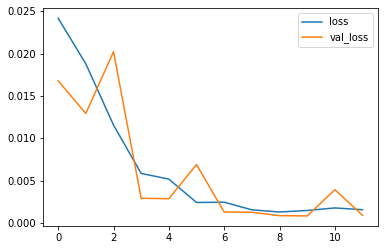

In [53]:
losses.plot()

In [55]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [56]:
true_predictions = scaler.inverse_transform(test_predictions)

In [57]:
test['Predictions'] = true_predictions

C:\Users\asus\AppData\Local\Temp/ipykernel_13232/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='DATE'>

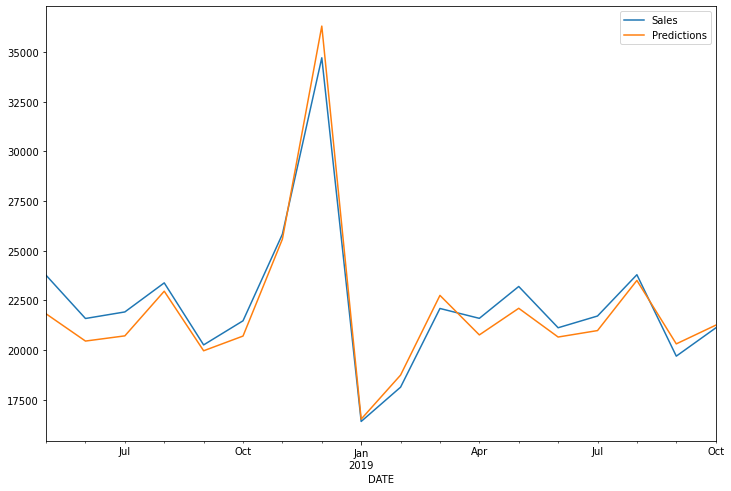

In [58]:
test.plot(figsize=(12,8))

# Retrain and Forecasting

In [59]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [60]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [61]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features),return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [62]:
model.fit(generator,epochs=12)

Epoch 1/12


C:\Users\asus\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


322/322 [==============================] - 41s 122ms/step - loss: 0.0263
Epoch 2/12
322/322 [==============================] - 40s 124ms/step - loss: 0.0187
Epoch 3/12
322/322 [==============================] - 45s 141ms/step - loss: 0.0128
Epoch 4/12
322/322 [==============================] - 52s 162ms/step - loss: 0.0070
Epoch 5/12
322/322 [==============================] - 56s 173ms/step - loss: 0.0053
Epoch 6/12
322/322 [==============================] - 60s 187ms/step - loss: 0.0028
Epoch 7/12
322/322 [==============================] - 64s 200ms/step - loss: 0.0018
Epoch 8/12
322/322 [==============================] - 67s 207ms/step - loss: 0.0020
Epoch 9/12
322/322 [==============================] - 68s 211ms/step - loss: 0.0013
Epoch 10/12
322/322 [==============================] - 71s 221ms/step - loss: 0.0013
Epoch 11/12
322/322 [==============================] - 76s 237ms/step - loss: 0.0015
Epoch 12/12
322/322 [==============================] - 73s 228ms/step - loss: 0.0014


In [63]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [64]:
forecast = scaler.inverse_transform(forecast)

In [65]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [66]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

<AxesSubplot:xlabel='DATE'>

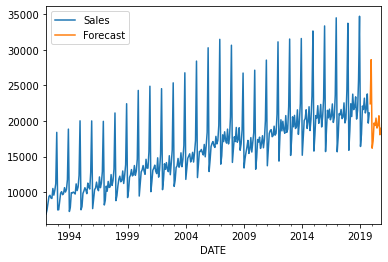

In [67]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

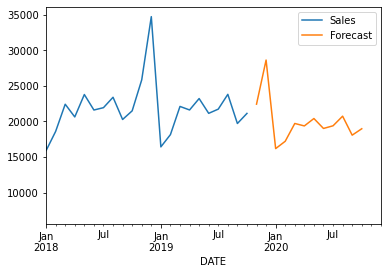

In [68]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')